# Installing dowhy package

If you want to install dowhy package within your existing python environment, you need to make sure that you have the correct dependencies installed. The dependencies can be found in the following link

https://github.com/py-why/dowhy/blob/main/pyproject.toml

A more convinient way (recommended) is to create a new python environemt 

conda create --name your_environment_name

Then, use the following command to install the dowhy library

conda install -c conda-forge dowhy

# Estimating Causal Effect of Grad School on Income

Code authored by: Shawhin Talebi <br>

Causal Effects via Regression: blog coming soon <br>
DoWhy Library: https://microsoft.github.io/dowhy/ <br>
Data from: https://archive.ics.uci.edu/ml/datasets/census+income

In this example, we estimate the causal effect of having a graduate degree on making more than $50k a year using the 3 different techniques. We use the open-source DoWhy library and open-access data from the UCI machine learning repository.

### Import modules

In [7]:
import pickle
import numpy as np
import dowhy
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns

### Load data

In [9]:
df = pickle.load(open("df_causal_effects.p", "rb")).astype(int)
df.head(10)

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [3]:
#sns.relplot(data=df, x="hasGraduateDegree", y="greaterThan50k", size="age")
sns.relplot(data=df, x="age", y="greaterThan50k", hue="hasGraduateDegree")

NameError: name 'df' is not defined

In [ ]:
sns.catplot(data=df, x="hasGraduateDegree", y="greaterThan50k", hue="age")

### Define causal model

In [2]:
model = dowhy.CausalModel(
        data = df,
        treatment= "hasGraduateDegree", # treatment variable
        outcome= "greaterThan50k", # outcome variable
        common_causes="age", # covariates
        )

NameError: name 'df' is not defined

#### Linear Regression
First we try linear regression.

We then define the causal effect as the coefficient for the treatment variable in the regression model estimating the outcome.

In [10]:
# Identify causal effect and return target estimands

estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Here, we only have a **backdoor criterion**. 

**Definition:** If all common causes of the action A and the outcome Y are observed, then the backdoor criterion implies that the causal effect can be identified by conditioning on all the common causes.

**Self study:** Read about "Instrumental variable (IV) identification" and "frontdoor"


In [11]:
LR_estimate = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
print(LR_estimate) # ATE 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.2976051357033027



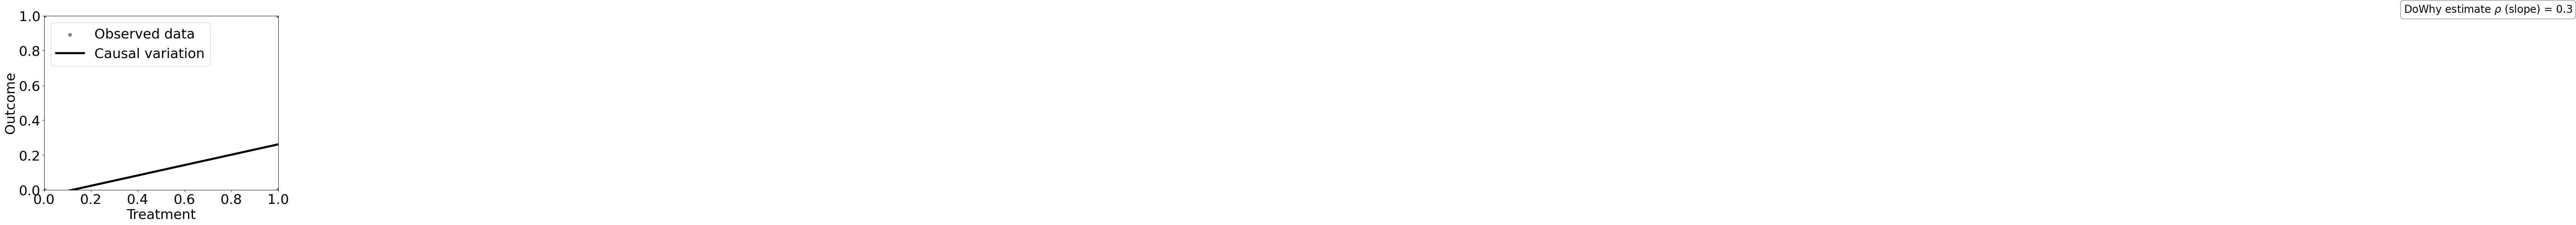

In [12]:
import dowhy.datasets, dowhy.plotter

# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(LR_estimate, df["hasGraduateDegree"], df["greaterThan50k"])

#### Double Machine Learning (T-learner)

Next, we try Double ML which is a bit overkill for this simple example, espeically with the treatment and outcome variable only taking values of 0 or 1. 

Note that the models we use in the DML process are all linear regression for this example, however more sophisticated techniques can be used for more complex problems.

In [ ]:
DML_estimate = model.estimate_effect(estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     method_params={"init_params":{
                                         'model_y':LinearRegression(),
                                         'model_t':LinearRegression(),
                                         'model_final':LinearRegression()
                                                                  },
                                                   "fit_params":{}
                                              })

In [ ]:
print(DML_estimate)

#### X-learner
Finally we try the X-learner making use of decision trees for our sub-models.

In [ ]:
Xlearner_estimate = model.estimate_effect(estimand,
                                method_name="backdoor.econml.metalearners.XLearner",
                                method_params={"init_params":{
                                                    'models': DecisionTreeRegressor()
                                                    },
                                               "fit_params":{}
                                              })

In [ ]:
print(Xlearner_estimate)